# Feature Selection

In this step, our focus is on selecting the most significant features that influence heart disease prediction. By narrowing down the dataset to only the most informative variables, we can minimize unnecessary complexity, enhance model interpretability, and ensure more reliable results.

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, chi2, SelectKBest
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
df = pd.read_csv("../Data/cleaned_heart_disease.csv")
df.head()

,age,trestbps,chol,thalach,oldpeak,num,sex_1,cp_2.0,cp_3.0,cp_4.0,...,restecg_1.0,restecg_2.0,exang_1.0,slope_2.0,slope_3.0,ca_1.0,ca_2.0,ca_3.0,thal_6.0,thal_7.0
0,0.948726,0.757525,-0.264900,0.017197,1.087338,0,True,False,False,False,...,False,True,False,False,True,False,False,False,True,False
1,1.392002,1.611220,0.760415,-1.821905,0.397182,1,True,False,False,True,...,False,True,True,True,False,False,False,True,False,False
2,1.392002,-0.665300,-0.342283,-0.902354,1.346147,1,True,False,False,True,...,False,True,True,True,False,False,True,False,False,True
3,-1.932564,-0.096170,0.063974,1.637359,2.122573,0,True,False,True,False,...,False,False,False,False,True,False,False,False,False,False
4,-1.489288,-0.096170,-0.825922,0.980537,0.310912,0,False,True,False,False,...,False,True,False,False,False,False,False,False,False,False


### Feature Importance Using Random Forest
We separate the features (X) from the target variable (y).Then, we train a RandomForestClassifier and extract feature importances to understand which features contribute most to the prediction. 

In [3]:
# Separate features (X) and target (y)
X = df.drop(columns=["num"])   # num = target
y = df["num"]

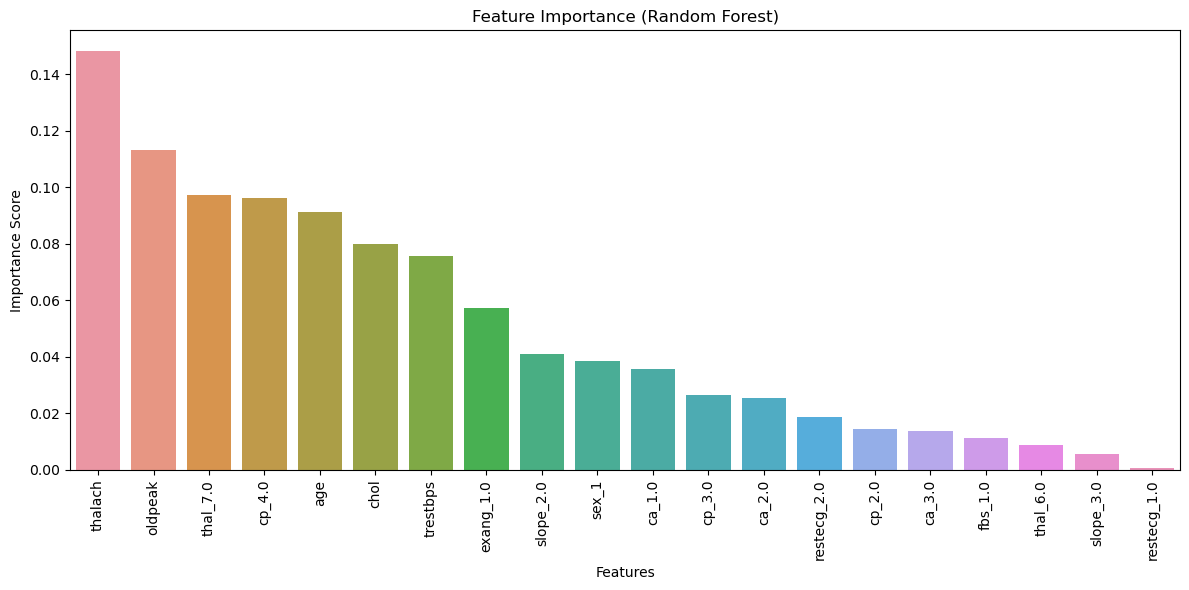

In [4]:
rf = RandomForestClassifier(random_state=42)
rf.fit(X, y)

# Get importance scores
importances = pd.Series(rf.feature_importances_, index=X.columns).sort_values(ascending=False)

# Plot
plt.figure(figsize=(12,6))
sns.barplot(x=importances.index, y=importances)
plt.xticks(rotation=90)
plt.title("Feature Importance (Random Forest)")
plt.xlabel("Features")
plt.ylabel("Importance Score")
plt.tight_layout()
plt.show()

In [5]:
# Print Feature Importances in Order
for feature, score in importances.items():
    print(f"{feature}: {score:.4f}")

thalach: 0.1482
oldpeak: 0.1133
thal_7.0: 0.0972
cp_4.0: 0.0961
age: 0.0914
chol: 0.0799
trestbps: 0.0757
exang_1.0: 0.0572
slope_2.0: 0.0409
sex_1: 0.0386
ca_1.0: 0.0357
cp_3.0: 0.0266
ca_2.0: 0.0256
restecg_2.0: 0.0187
cp_2.0: 0.0145
ca_3.0: 0.0140
fbs_1.0: 0.0112
thal_6.0: 0.0087
slope_3.0: 0.0058
restecg_1.0: 0.0007


### Feature Selection Using Recursive Feature Elimination (RFE)
we apply RFE with a Logistic Regression model to select the top 10 most important features. RFE works by recursively removing less important features and building the model repeatedly until the desired number of features is reached.

In [6]:
# Use Logistic Regression as estimator
model = LogisticRegression(max_iter=1000)
rfe = RFE(model, n_features_to_select=10)   # keep best 10 features
rfe.fit(X, y)

selected_features_rfe = X.columns[rfe.support_]
print("Selected Features by RFE:", selected_features_rfe.tolist())

Selected Features by RFE: ['oldpeak', 'sex_1', 'cp_2.0', 'cp_4.0', 'exang_1.0', 'slope_2.0', 'ca_1.0', 'ca_2.0', 'ca_3.0', 'thal_7.0']


### Feature Selection Using Chi-Square Test
We apply the Chi-Square statistical test to evaluate the relationship between each feature and the target variable.  
The Chi-Square test measures whether observed differences in frequency distributions are due to chance or if they indicate a significant association.  

In [7]:
# Keep a copy of feature names before scaling
feature_names = X.columns  

# Scale features to non-negative for Chi2
X_scaled = MinMaxScaler().fit_transform(X)

# Apply Chi-Square test
chi_selector = SelectKBest(score_func=chi2, k=10)   # select top 10
X_chi = chi_selector.fit_transform(X_scaled, y)

# Get selected features
selected_features_chi = feature_names[chi_selector.get_support()]
print("Selected Features by Chi-Square:", selected_features_chi.tolist())

Selected Features by Chi-Square: ['oldpeak', 'cp_2.0', 'cp_3.0', 'cp_4.0', 'exang_1.0', 'slope_2.0', 'ca_1.0', 'ca_2.0', 'ca_3.0', 'thal_7.0']


### Final Selection

In [8]:
# Intersection of RFE, RandomForest, and Chi-Square top features
final_features = set(selected_features_rfe) | set(selected_features_chi) | set(importances.head(10).index)
print("Final Selected Features:", final_features)

Final Selected Features: {'ca_2.0', 'thal_7.0', 'thalach', 'age', 'cp_2.0', 'exang_1.0', 'sex_1', 'cp_3.0', 'slope_2.0', 'cp_4.0', 'chol', 'trestbps', 'ca_3.0', 'oldpeak', 'ca_1.0'}


In [9]:
X_reduced = df[list(final_features)].copy()
X_reduced["num"] = y
X_reduced.to_csv("heart_disease_features_selected.csv", index=False)